In [214]:
import os
import collections
import string
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import *
import re
import time

import tqdm
from tqdm import tqdm
from tqdm import trange
import einops
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils  import *

import numpy as np
from collections import Counter   # Dict subclass for counting hashable items

import pickle
from pickle import dump
import random
import  nltk.translate.bleu_score as bleu

from model_architecture import *
import cv2

In [215]:
max_len = 31
vocab_size = 8136

pickle_in = open("/content/drive/MyDrive/ImageCaptioning/Pickles/Tokenizer.pkl","rb")
tokenizer = pickle.load(pickle_in)

pickle_in = open('/content/drive/MyDrive/ImageCaptioning/Pickles/captions.pkl' , 'rb')
captions = pickle.load(pickle_in)

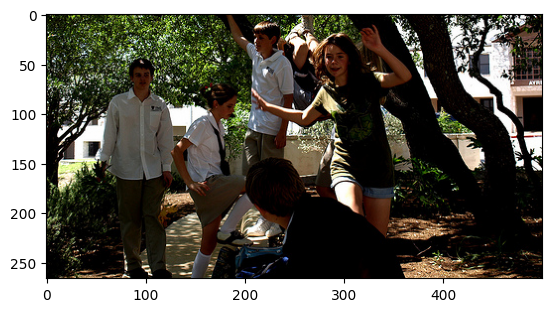

In [217]:
import matplotlib.image as mpimg

path = '/content/drive/MyDrive/ImageCaptioning/Images'

r1 = random.randint(0, len(captions))
img_path = os.path.join(path , captions.iloc[r1,1])
real_caption = captions.iloc[r1, 0]
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

In [218]:
model = Captioner(max_length = max_len, vocab_size= vocab_size,tokenizer = tokenizer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)


Uniform entropy: 9.00
Marginal entropy: 5.69


In [219]:
model.load_weights('/content/drive/MyDrive/ImageCaptioning/model_weights')

In [220]:
def load_image(img_path):
    img = tf.io.read_file(img_path)           # returns tensor of dtype "string", with the file contents.
    img = tf.image.decode_jpeg(img, channels=3)   # returns tensor of type uint8.
    img = tf.image.resize(img, (256, 256))
    return img, img_path

img1, path = load_image(img_path)
img1 = tf.expand_dims(img1 , axis = 0)

In [221]:
image_model = tf.keras.applications.resnet50.ResNet50(
                                                      include_top=False,
                                                      weights='imagenet',
                                                      input_shape = (256, 256, 3)
                                                      )
image_model.trainable = False

new_input = image_model.input                 # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [222]:
batch_features = image_features_extract_model(img1)
batch_features = tf.reshape(batch_features,
                            (batch_features.shape[0], -1, batch_features.shape[3]))

In [223]:
pred_caption = model.simple_gen(batch_features)

In [224]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 10, 64]), TensorShape([1, 2, 10, 64])]

In [225]:
!pip install einops


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [226]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=8, width=8,
    reduction='mean')



def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [227]:
str_tokens = pred_caption.split()
str_tokens.append('<end>')
img1 = tf.squeeze(img1 , axis= 0)/255


real_caption :  <start>  group of boys and girls sit and talk together under tree <end>
pred_caption :    man and woman smile while walking on grassy boardwalk 
BLEU Score:  0


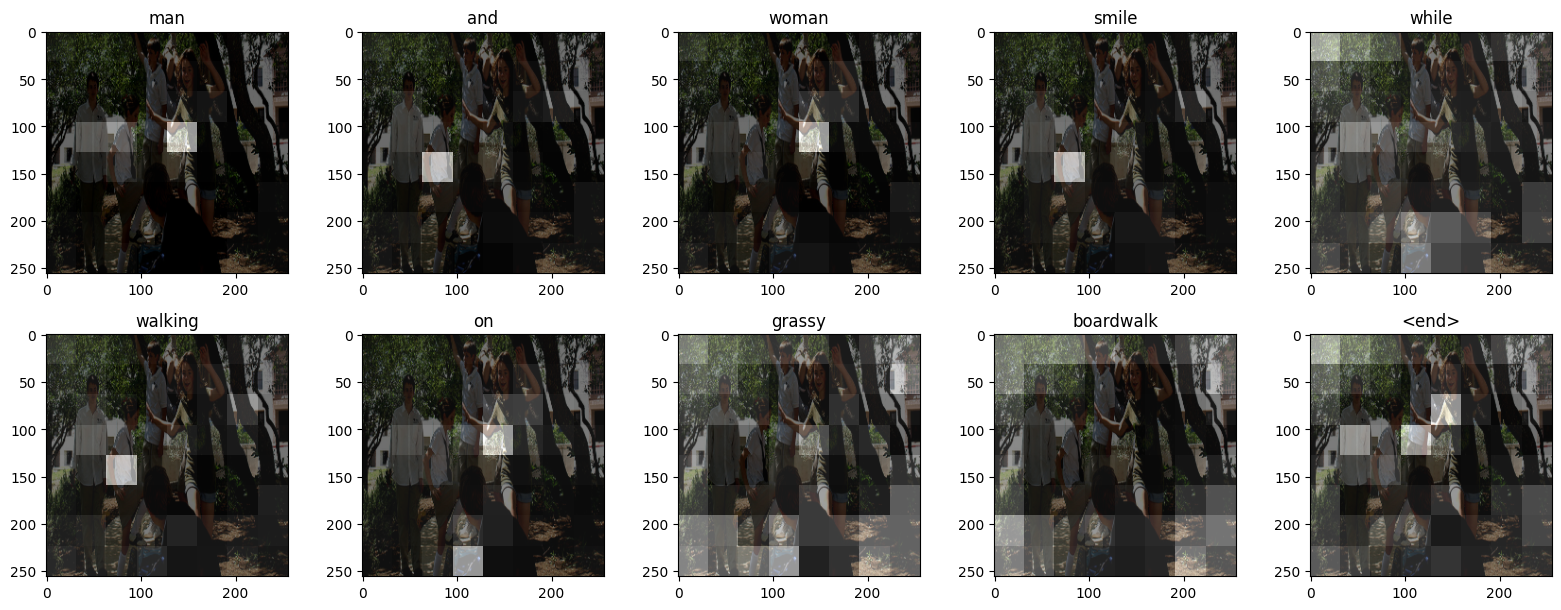

In [228]:
plot_attention_maps(img1, str_tokens, attention_maps)
print('real_caption : ' , real_caption)
print('pred_caption : ' , pred_caption)
print("BLEU Score: ",bleu.sentence_bleu(real_caption.split(), str_tokens))